# Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

# Цель: 
разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

# Описание данных
Данные для работы находятся в нескольких таблицах:

**market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

id — номер покупателя в корпоративной базе данных.

Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

Выручка — сумма выручки за период.

**market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксировано общее время.

минут — значение времени, проведённого на сайте, в минутах.

**money.csv**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

id — номер покупателя в корпоративной базе данных.

Прибыль — значение прибыли.

In [99]:
!pip install shap
!pip install -Uq scikit-learn
!pip install phik

In [100]:

#Импорт библиотек, моделей, функций
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

RANDOM_STATE = 42
TEST_SIZE = 0.25

plt.rcParams["figure.figsize"] = (12,10)

## ЗАГРУЗКА ДАННЫХ

In [101]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=";", decimal=",")

In [102]:
display(market_file.head(), 
        market_file.info(), 
        market_file.describe(), 
        market_file.duplicated().sum(), 
        market_file.shape, 
        market_file.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


0

(1300, 13)

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [103]:
display(market_money.head(), 
        market_money.info(), 
        market_money.describe(), 
        market_money.duplicated().sum(), 
        market_money.shape, 
        market_money.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


None

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


0

(3900, 3)

id         0
Период     0
Выручка    0
dtype: int64

In [104]:
display(market_time.head(), 
        market_time.info(), 
        market_time.describe(), 
        market_time.duplicated().sum(), 
        market_time.shape, 
        market_time.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


None

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


0

(2600, 3)

id        0
Период    0
минут     0
dtype: int64

In [105]:
display(money.head(), 
        money.info(), 
        money.describe(), 
        money.duplicated().sum(), 
        money.shape, 
        money.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


None

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


0

(1300, 2)

id         0
Прибыль    0
dtype: int64

**Вывод по загрузке данных:** в целом с данными всё в порядке, отстутсвуют дубликаты и пропуски. Есть необходимость привести к "змеиному регистру" некоторые названия столбцов, исправить опечатки.

## ПРЕДОБРАБОТКА ДАННЫХ

In [106]:
#Приведем к змеиному регистру столбцы в датасетах
market_file = market_file.rename(columns={
                                'Покупательская активность': 'покупательская_активность',
                                'Тип сервиса': 'тип_сервиса',
                                'Разрешить сообщать': 'разрешить_сообщать',
                                'Маркет_актив_6_мес':'актив_6_мес', 
                                'Маркет_актив_тек_мес':'маркет_актив_тек_мес', 
                                'Длительность':'длительность', 
                                'Акционные_покупки':'акционные_покупки', 
                                'Популярная_категория':'популярная_категория', 
                                'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит', 
                                'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал', 
                                'Ошибка_сервиса':'ошибка_сервиса', 
                                'Страниц_за_визит':'страниц_за_визит' })

market_money = market_money.rename(columns={'Период': 'период', 
                                  'Выручка': 'выручка'})

market_time = market_time.rename(columns={'Период':'период', 
                            'минут':'минут'})

money = money.rename(columns={'Прибыль':'прибыль'})

display(market_file.head(), market_money.head(), market_time.head(), money.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [107]:
#Исправим опечатки
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

display(market_file.head(), market_money.head(), market_time.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


**Вывод по предобработке данных:** были приведены к "змеиному регистру" столбцы, были исправлены опечатки.

## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

**Задачи:** проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [108]:
#Составим список id которые не совершали покупок в течение предыдущего или препредыдущего месяцев
df_to_del = pd.pivot_table(market_money, index='id', columns='период', values='выручка')
#Добавляем все id покупателей, после проведения всего анализа удалим покупателей не подходящих под условия
id_list_to_del=df_to_del[(df_to_del['предыдущий_месяц']== 0) | (df_to_del['препредыдущий_месяц']==0)].index.tolist()

id_list_to_del

[215348, 215357, 215359]

3 покупателя не совершали покупки за последние 3 месяца.

In [109]:
_num_cols = market_file[market_file.columns[(market_file.columns != 'id') & (market_file.columns != 'длительность')]].select_dtypes(include='number').columns
_num_cols

Index(['актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

### **market_file**

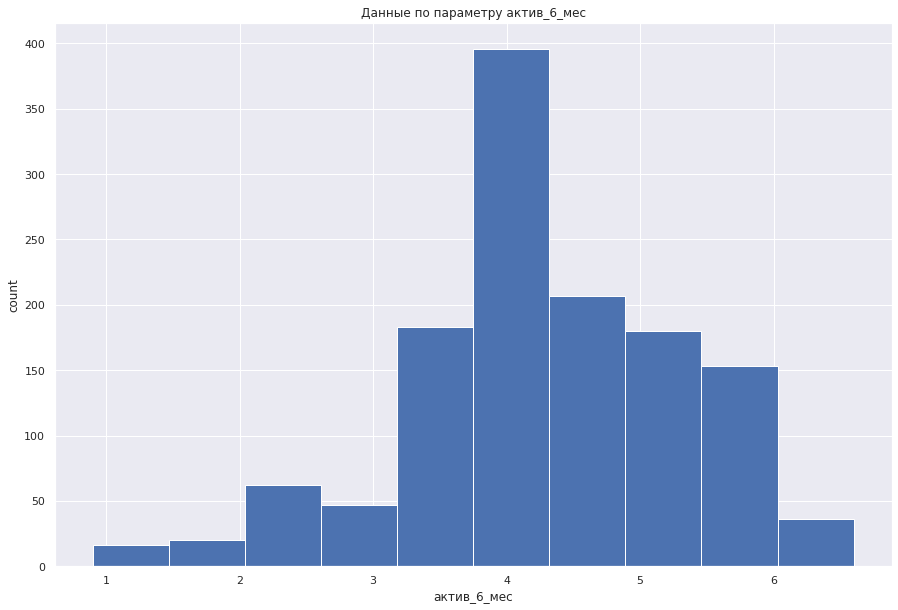

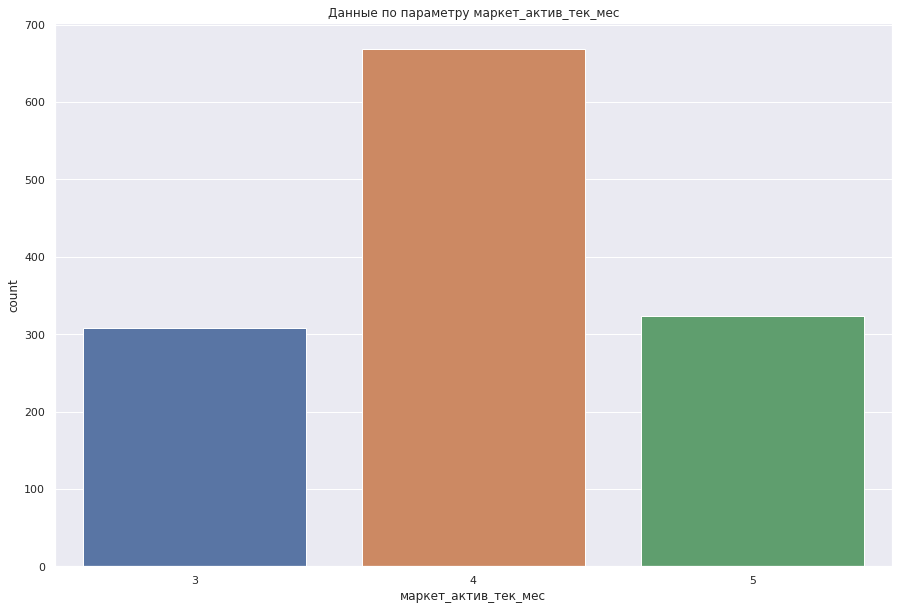

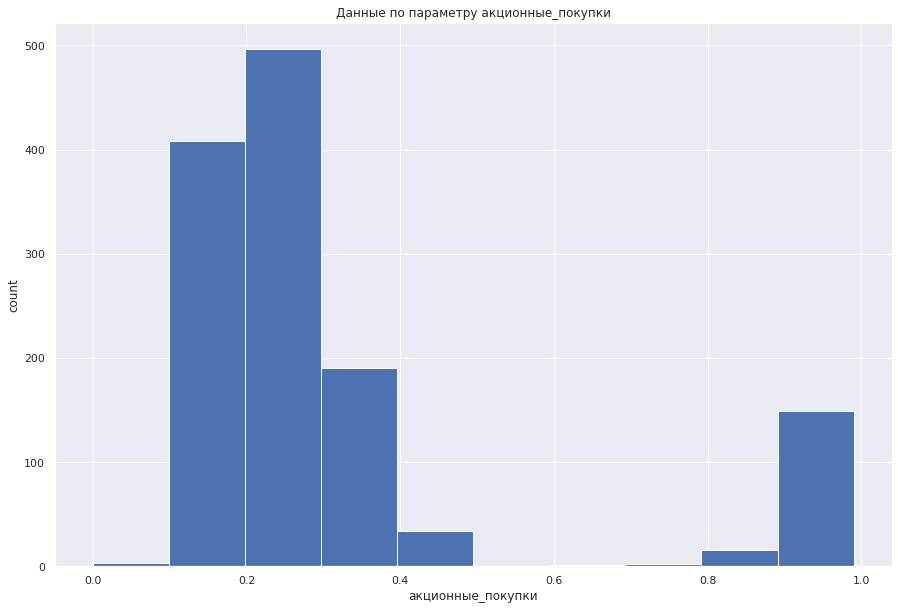

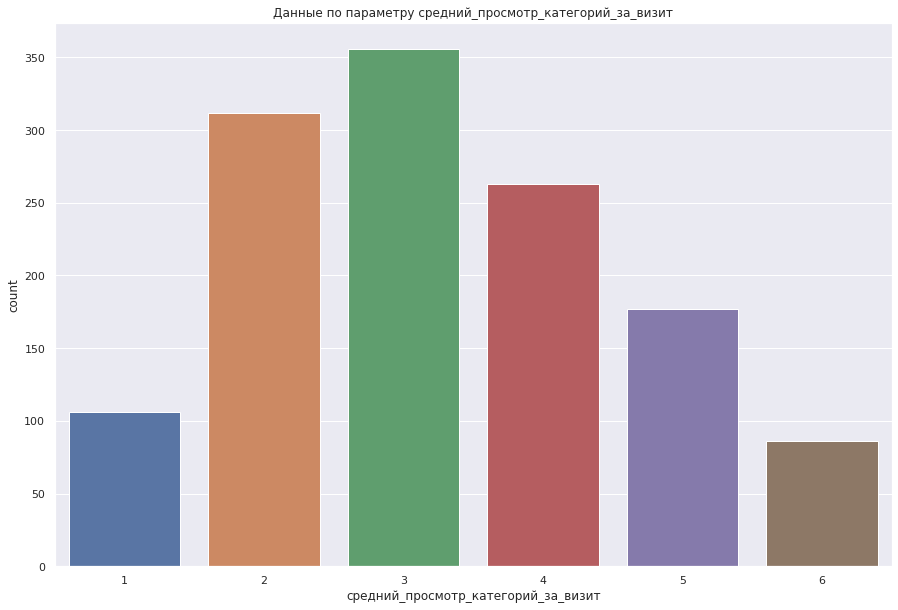

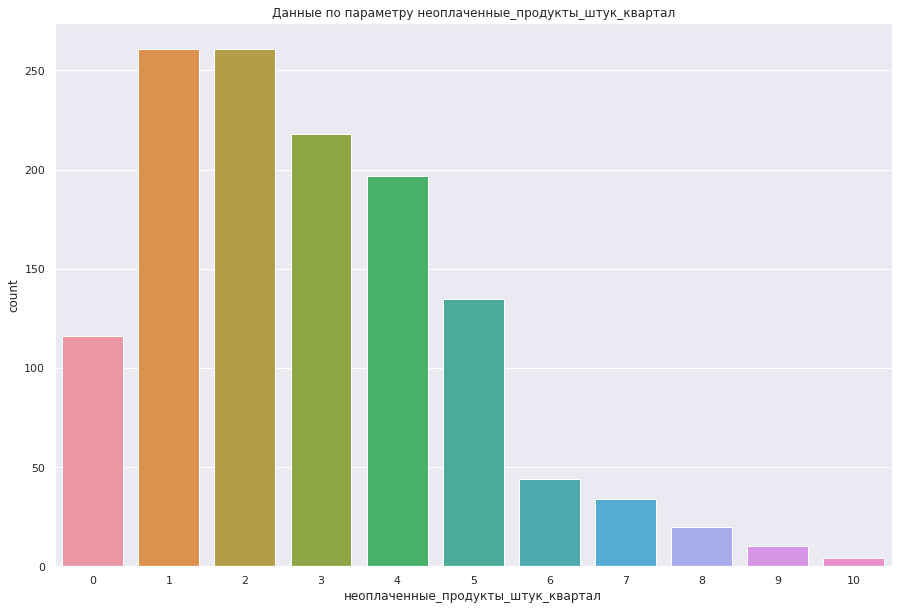

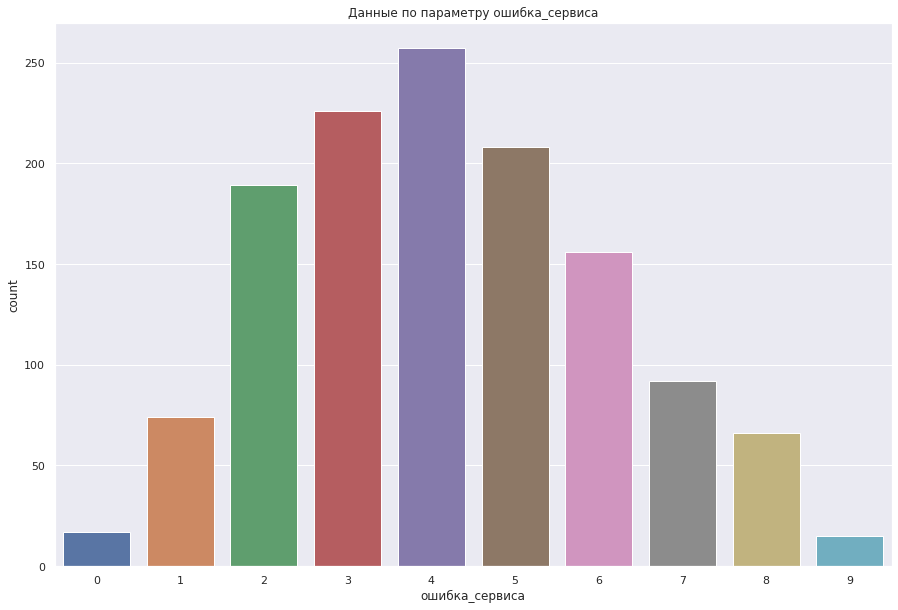

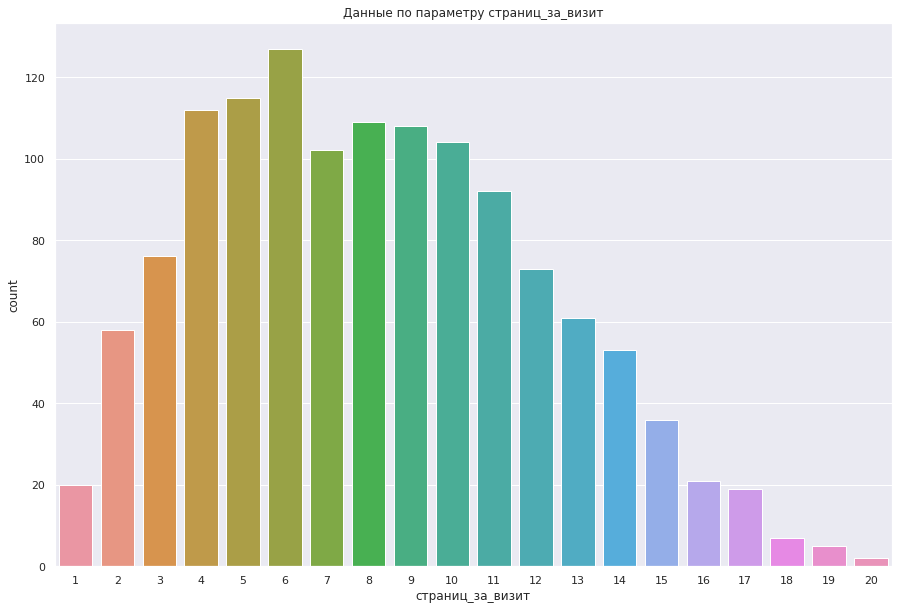

In [110]:
sns.set_theme(rc={'figure.figsize':(15,10)})
for column in _num_cols:
    plt.figure()
    plt.title(f'Данные по параметру {column}')
    
    if market_file[column].dtypes == 'int64':
        sns.countplot(x=column, data=market_file)
        
    else:
        market_file[column].plot(kind='hist', y='count')
    plt.xlabel(column)    
    plt.ylabel('count')
    plt.show()

В целом данные выглядят нормально. В акционные_покупки есть разделение на 2 группы.

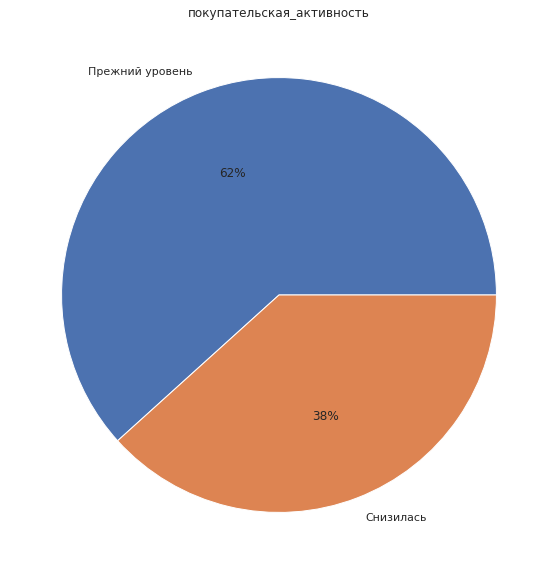

In [111]:
market_file['покупательская_активность'].value_counts().plot(title='покупательская_активность', label='',
                                                                  kind='pie', autopct = '%1.0f%%', figsize=(10,10));

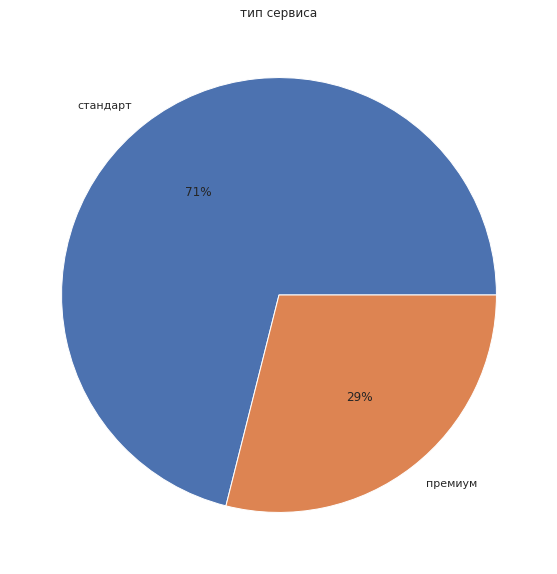

In [112]:
market_file['тип_сервиса'].value_counts().plot(title='тип сервиса', label='', kind='pie',
                                                    autopct = '%1.0f%%',figsize=(10,10));

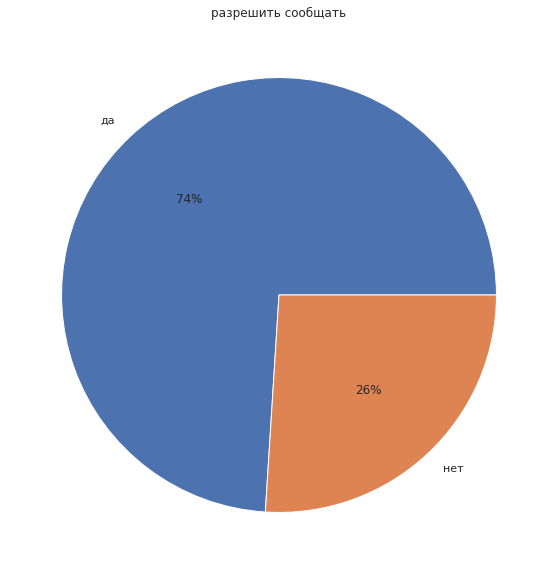

In [113]:
market_file['разрешить_сообщать'].value_counts().plot(title='разрешить сообщать', label='',
                                                           kind='pie', autopct = '%1.0f%%', figsize=(10,10));

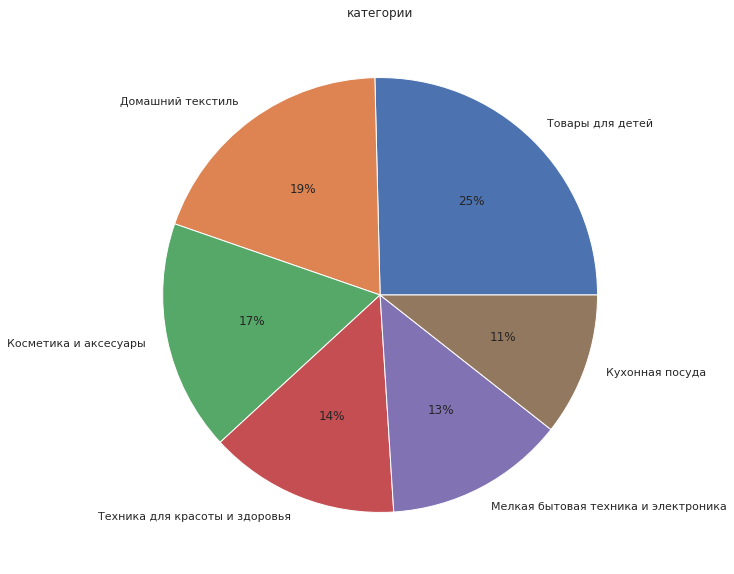

In [114]:
market_file['популярная_категория'].value_counts().plot(title='категории',label='', 
                                                             kind='pie', autopct = '%1.0f%%', figsize=(10,10));

По категориальным признакам было замечено:

- покупательская активность у 38% снизилась

- 29% покупателей выбирают премиум подписку

- 26% покупателей отказываются от рассылки

- 25% покупателей совершают покупки в категории товары для детей

### **market_money**

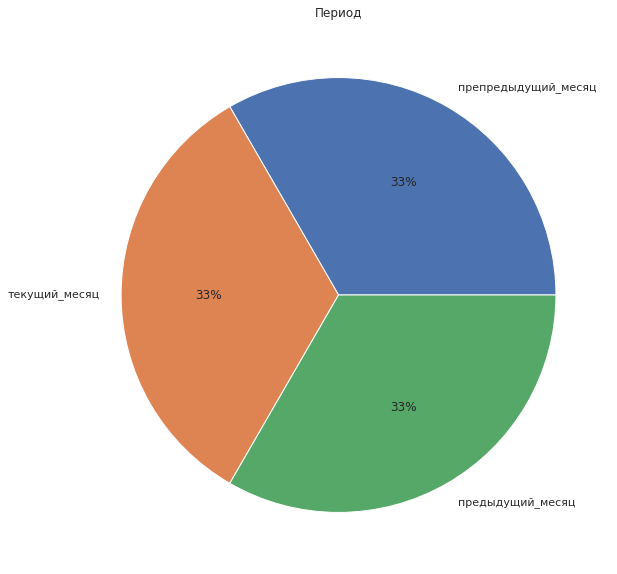

In [115]:
market_money['период'].value_counts().plot(title='Период', label='',
                                                kind='pie', autopct = '%1.0f%%', figsize=(10,10));

Одиннаковое количество данных в каждом периоде.

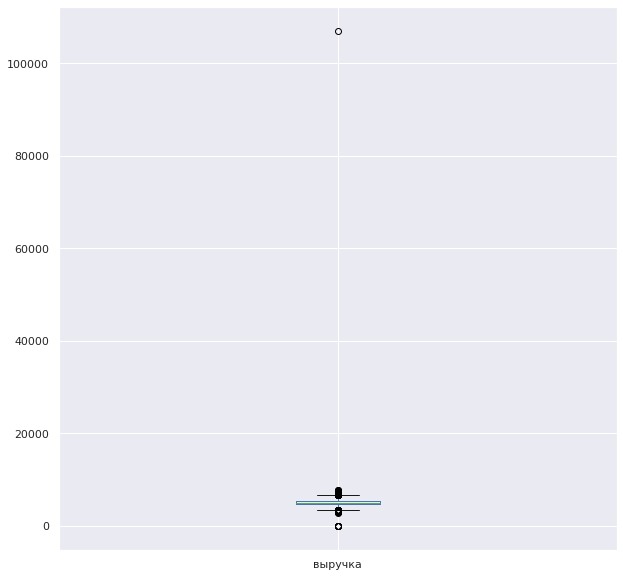

In [116]:
market_money['выручка'].plot(kind='box', figsize=(10,10));

In [117]:
market_money[market_money['выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


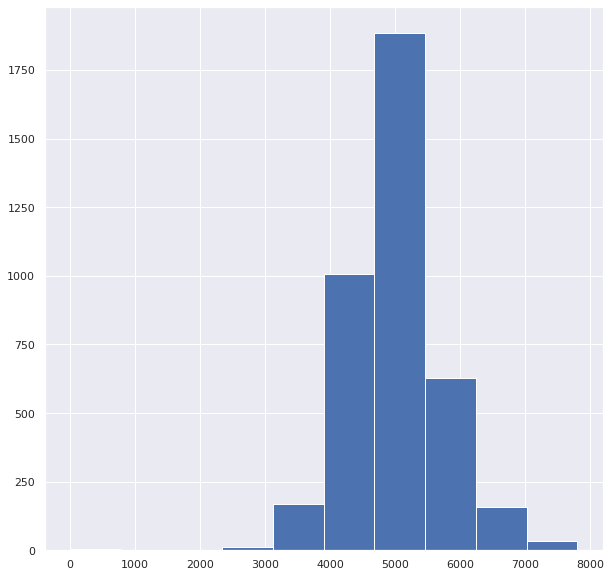

In [118]:
market_money[market_money['выручка'] < 20000]['выручка'].hist(bins=10, figsize=(10,10));

Теперь распределение нормальное

In [119]:
#получим список id с выбросами по выручке
_id_list = list(market_money.loc[market_money[market_money['выручка'] > 20000].index]['id'])
_id_list

[215380]

In [120]:
#добавим id в список для удаления
id_list_to_del.extend(_id_list)

### **market_time**

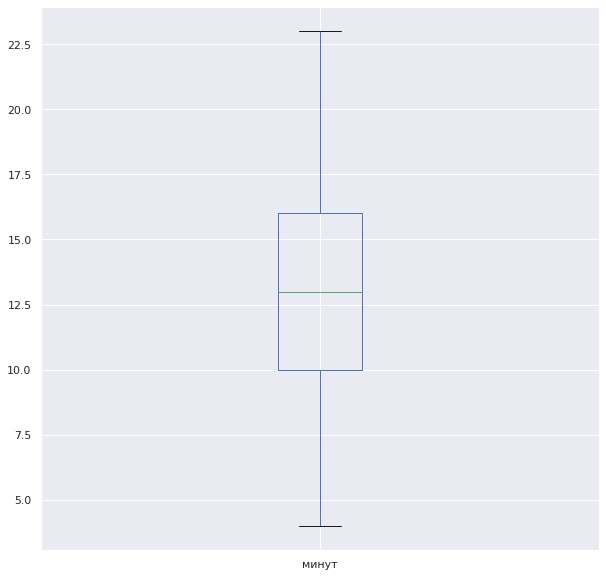

In [121]:
market_time['минут'].plot(kind='box', figsize=(10,10));

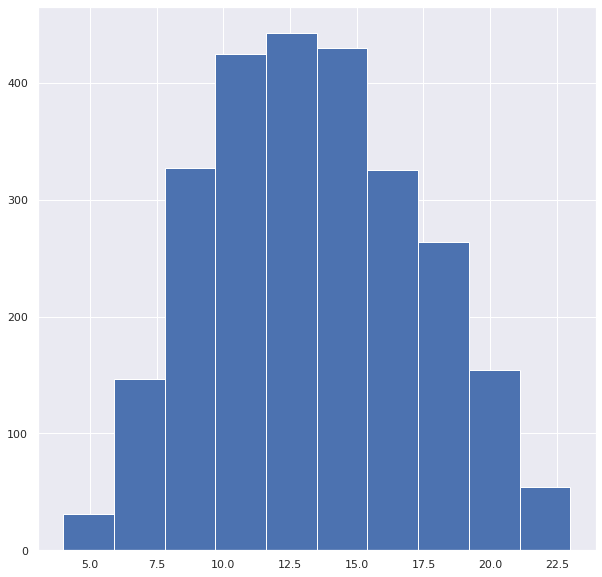

In [122]:
market_time['минут'].hist(bins=10, figsize=(10,10));

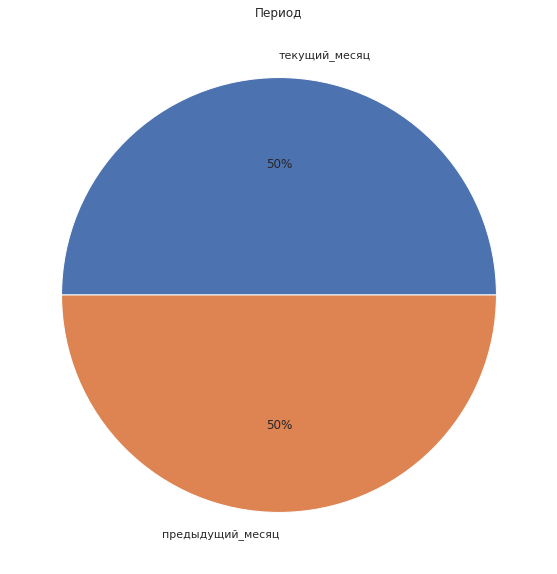

In [123]:
market_time['период'].value_counts().plot(title='Период', label='',
                                               kind='pie', autopct = '%1.0f%%', figsize=(10,10));

### **money**

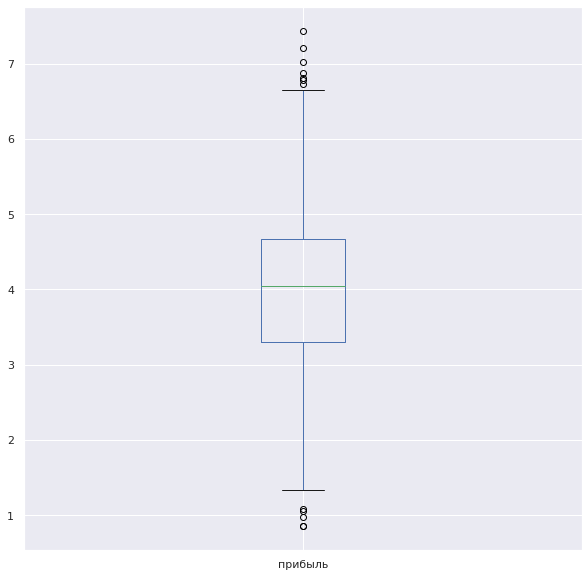

In [124]:
money['прибыль'].plot(kind='box', figsize=(10,10));

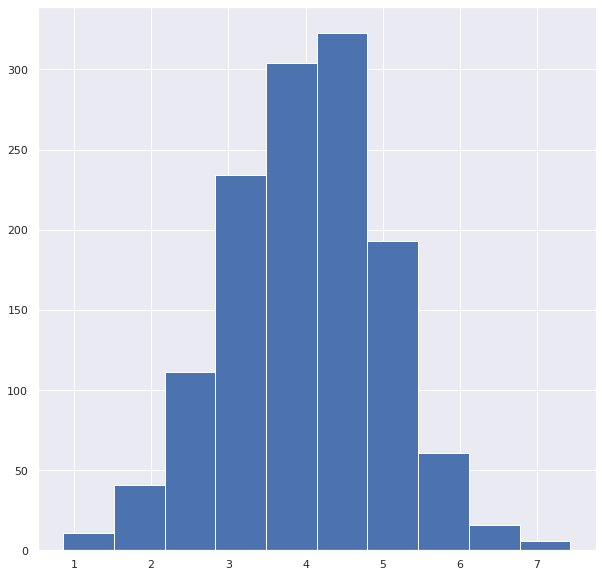

In [125]:
money['прибыль'].hist(figsize=(10,10));

In [126]:
# Удалим id, которые нас не интересуют из всех таблиц
market_file.drop(market_file[(market_file['id'].isin(id_list_to_del))].index, inplace = True)
market_money.drop(market_money[(market_money['id'].isin(id_list_to_del))].index, inplace = True)
market_time.drop(market_time[(market_time['id'].isin(id_list_to_del))].index, inplace = True)
money.drop(money[(money['id'].isin(id_list_to_del))].index, inplace = True)

**Вывод по исследовательскому анализу данных:** были рассмотрены распределения признаков датасетов, взглянули на круговые диаграммы категориальных признаков, составили список *id*, которые удалили.

## ОБЪЕДИНЕНИЕ ТАБЛИЦ

**Задачи:** объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [127]:
market_money = market_money.pivot_table(index='id', columns='период')
market_money.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий месяц', 'выручка_текущий_месяц']
market_money.head()

,выручка_предыдущий_месяц,выручка_препредыдущий месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [128]:
market_time = market_time.pivot_table(index='id', columns='период')
market_time.columns= ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time.head()

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [129]:
market_full = market_file.join(market_time, on='id')
market_full = market_full.join(market_money, on='id')
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   актив_6_мес                          1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

**Вывод по объединению таблиц:** объединение прошло успешно, столбцы разделены по периодам.

## КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

**Задачи:** проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

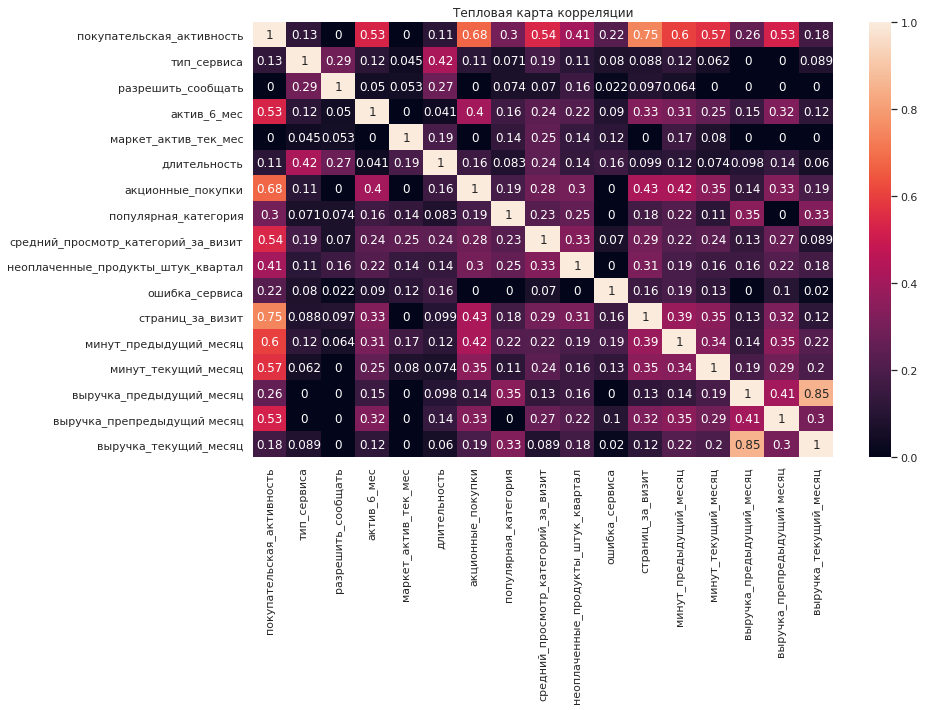

In [130]:
#Переведем id в индекс
market_full.set_index('id', inplace=True)

interval_cols = ['актив_6_мес', 'длительность', 'акции', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий месяц']

plt.figure(figsize=(13, 8))
sns.heatmap(market_full.phik_matrix(interval_cols=interval_cols, bins=6), annot=True) 
plt.title("Тепловая карта корреляции")
plt.show()

**Вывод по корреляционному анализу:** построили матрицу корреляций, мультиколлинеарность не наблюдается, самая большая корреляция признака "Покупательская активность" наблюдается с признаками страниц_за_визит (0.75), акционные_покупки (0.68), минут_предыдущий_месяц (0.6).

## ИСПОЛЬЗОВАНИЕ ПАЙПЛАЙНОВ

**Задачи:** Примените все изученные модели. Для этого используйте пайплайны.
    
Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

*Целевой признак - покупательская_активность*

In [131]:
X=market_full.drop('покупательская_активность', axis=1)
y=market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

label_encoder = LabelEncoder()

y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)
label_encoder.classes_
pd.DataFrame(y_train_label, y_train, columns=['LabelEncoder'])

,LabelEncoder
покупательская_активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
...,...
Прежний уровень,0
Прежний уровень,0
Снизилась,1


In [132]:
ohe_col = ['популярная_категория']
ord_col = ['тип_сервиса', 'разрешить_сообщать']
num_col = ['актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц','выручка_предыдущий_месяц',
       'выручка_препредыдущий месяц', 'выручка_текущий_месяц']

ohe_pipe = Pipeline([
        ('simple_imputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

ord_pipe = Pipeline([
        ('simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',OrdinalEncoder(categories=[
                                      ['стандарт','премиум'],
                                      ['да', 'нет']],
                        handle_unknown='use_encoded_value',
                        unknown_value=np.nan)),
        ('simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_col),
     ('ohe', ohe_pipe, ohe_col),
     ('num', MinMaxScaler(), num_col)], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 7),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

randomized_search.fit(X_train, y_train_label)



RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simple_imputer_ord_before',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум'],
                                                                                                                           ['да',
                                                                                                                            'нет']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simple_...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [133]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', round(randomized_search.best_score_, 5))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                                                                                               'нет']],
                                                                                  handle_unknown='use_encoded_value',
  

In [134]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_label, y_test_proba[:,1]), 5)}')

Метрика ROC-AUC на тестовой выборке: 0.91668


In [135]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test_label, y_test_pred), 5)}')

Метрика F1-score на тестовой выборке: 0.86325


**Вывод по использованию пайплайнов:** Лучшая модель - LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика на кросс-валидационной выборке 0.896, метрика ROC-AUC на тестовой выборке: 0.91668, Метрика F1-score на тестовой выборке: 0.86325. На тестовой выборке метрики показывают близкие результаты, что говорит о том, что модель имеет сбалансированный результат.

## АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

**Задачи:** оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

Сделайте выводы о значимости признаков:

какие признаки мало значимы для модели;

какие признаки сильнее всего влияют на целевой признак;

как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

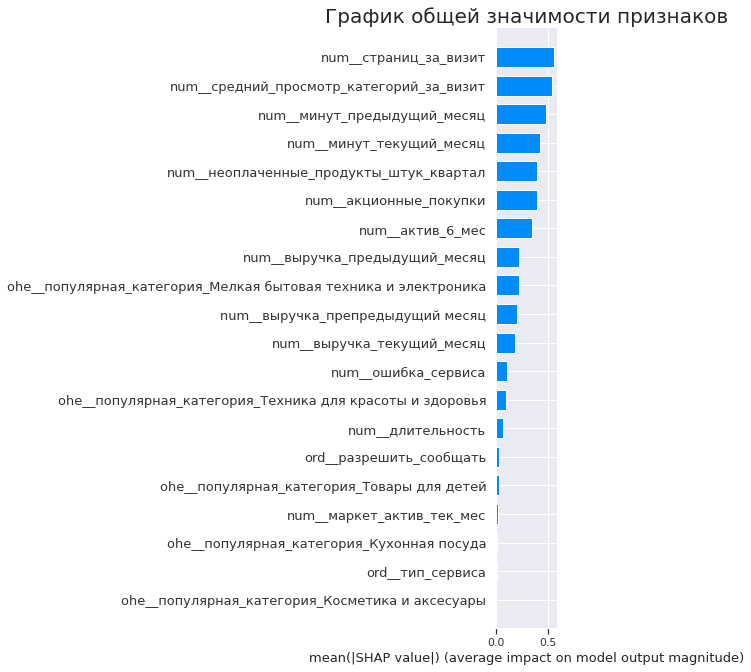

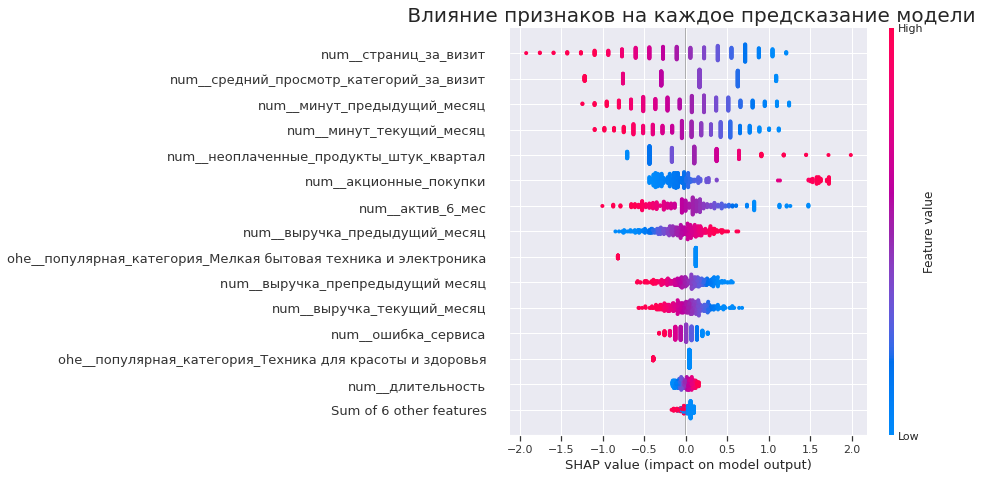

In [136]:
X_encoded_1 = randomized_search.best_estimator_['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_['preprocessor'].transform(X_test)

feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer_1 = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_encoded_1, feature_names=feature_names)
shap_values = explainer_1(X_test_df)

plt.title('График общей значимости признаков',  fontdict = {'fontsize' : 20})
shap.summary_plot(shap_values, plot_type='bar', feature_names=feature_names) 
plt.title(' Влияние признаков на каждое предсказание модели', fontdict = {'fontsize' : 20})
shap.plots.beeswarm(shap_values,  max_display=15)

**Выводы по анализу важности признаков:**

Параметры влияющие на активность: 

- страниц_за_визит
- средний_просмотр_категорий_за_визит
- минут_предыдущий_месяц
- минут_текущий_месяц
- неоплаченные_продукты_штук_квартал
- акционные_покупки 

## СЕГМЕНТАЦИЯ ПОКУПАТЕЛЕЙ

**Задачи:** выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей. Выберите группу покупателей и предложите, как увеличить её покупательскую активность. Сделайте выводы о сегментах.

In [137]:
#Построим диаграмму рассеяния прибыли и вероятности снижения активности пользователей, которую определила модель
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]
money.head()

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [138]:
#Создадим датафрейм с данными о покупателях из тестовой выборки с доп. информацией
X_test_full = X_test.copy()

X_test_full['вероятность_снижения'] = y_test_proba

money = money.set_index('id')
X_test_full = X_test_full.join(money)

In [139]:
data_low_activity = X_test_full[X_test_full['вероятность_снижения'] > 0.90]
data_high_activity = X_test_full[X_test_full['вероятность_снижения'] < 0.10]
data_low_activity.head()

,тип_сервиса,разрешить_сообщать,актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий месяц,выручка_текущий_месяц,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,11,9,3548.0,4656.0,4170.7,0.988923,2.75
215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,8,9,5253.5,4715.0,5633.1,0.970751,4.18
215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,11,10,4045.0,4963.0,4206.2,0.951158,4.50
215484,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,5,7,5059.0,4267.0,5018.7,0.921347,5.64
215671,премиум,да,4.0,4,820,0.22,Косметика и аксесуары,1,4,8,6,7,8,5379.5,4670.0,6034.7,0.932599,3.73


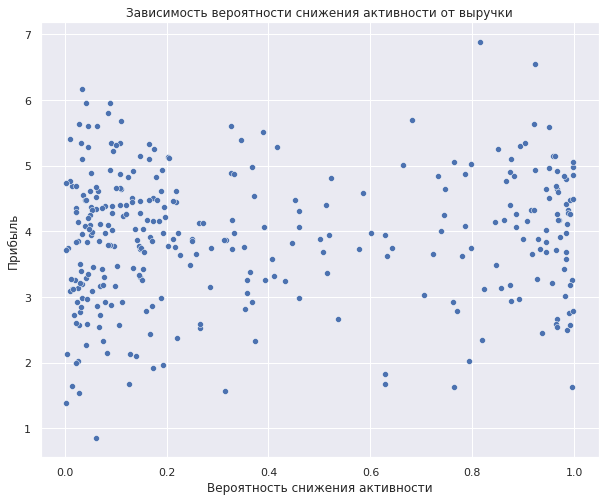

In [140]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=X_test_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

In [141]:
def show_scatterplots(cat_col, df):
    for col in cat_col:
        fig = plt.figure(figsize=(10,10))
        sns.scatterplot(data=df, y='прибыль', x='вероятность_снижения', hue=col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title(f'Зависимость вероятности снижения активности от {col}')
        plt.show()

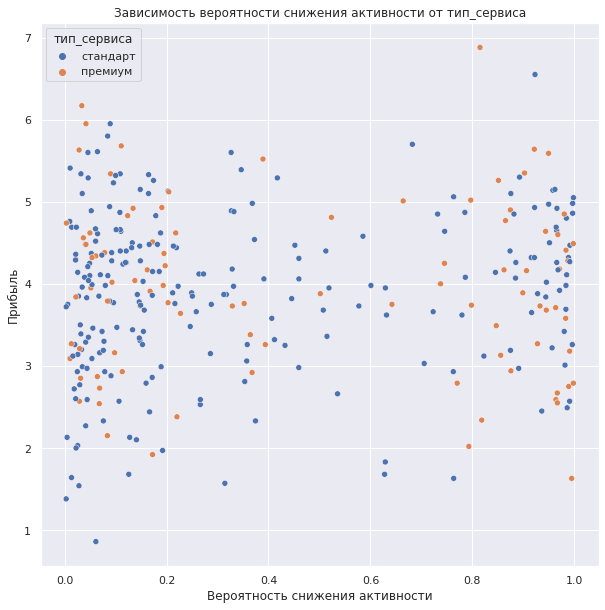

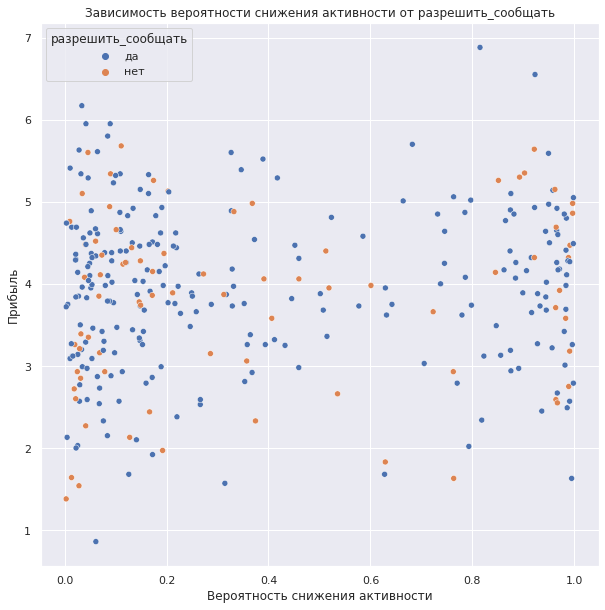

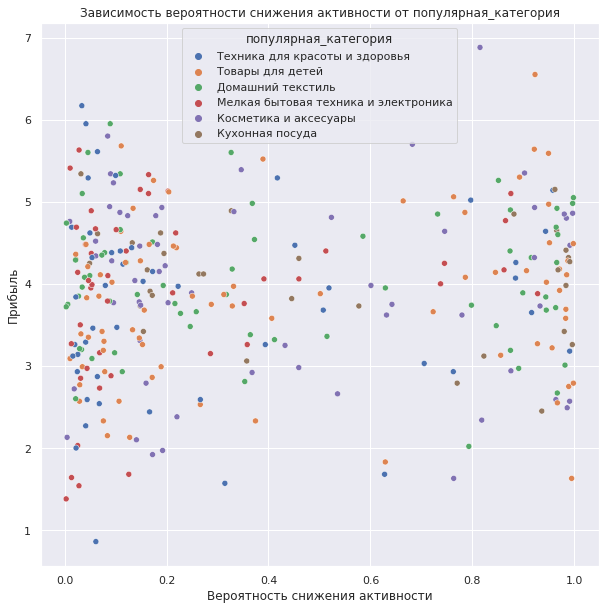

In [142]:
cat_col = list(X_test_full.select_dtypes(include='object').columns)
show_scatterplots(cat_col, X_test_full)

In [143]:
#Отберем пользователей, которым модель предстказала снижение активности
data_low_activity = X_test_full[X_test_full['вероятность_снижения'] > 0.90]
data_high_activity = X_test_full[X_test_full['вероятность_снижения'] < 0.10]

In [144]:
#Создадим список важных признаков
high_impact = ['акционные_покупки',
               'минут_текущий_месяц',
               'минут_предыдущий_месяц',
               'страниц_за_визит',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал' ]

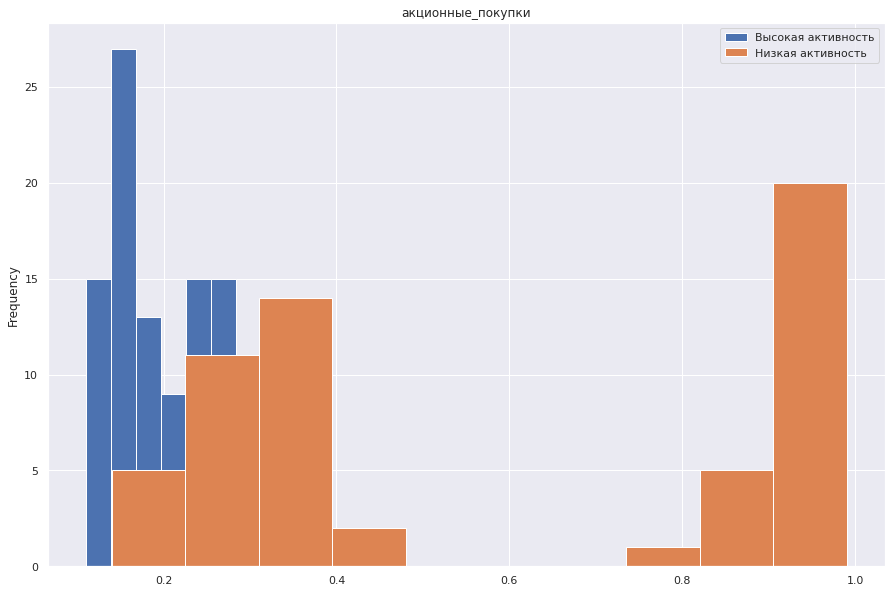

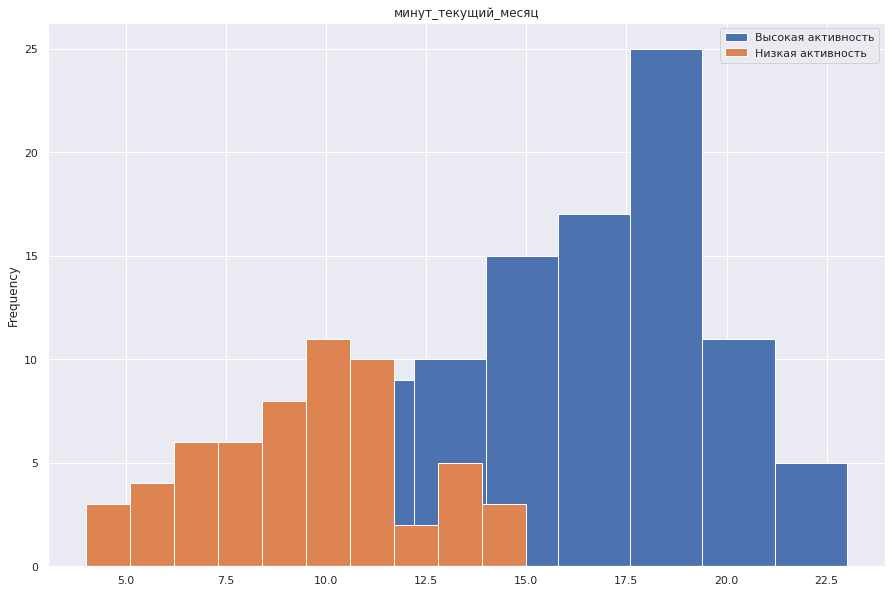

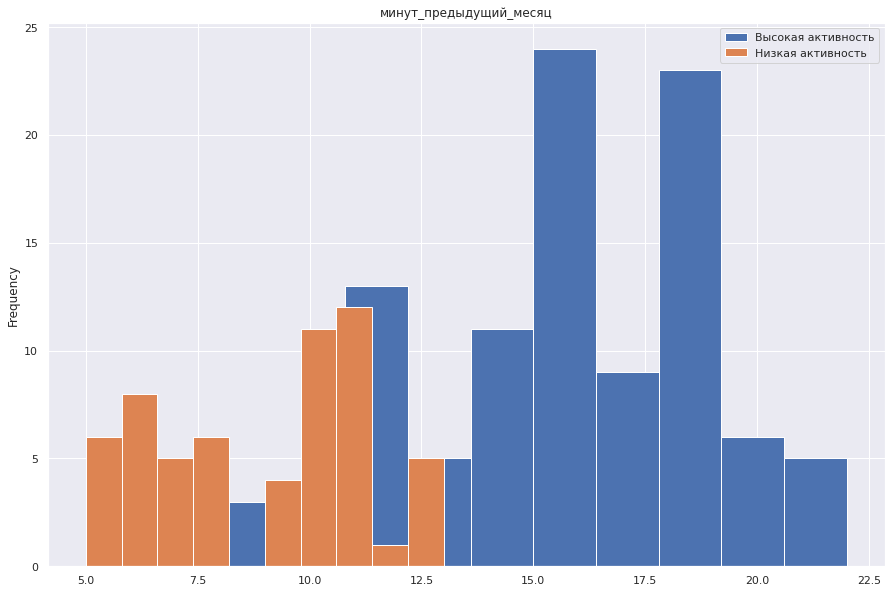

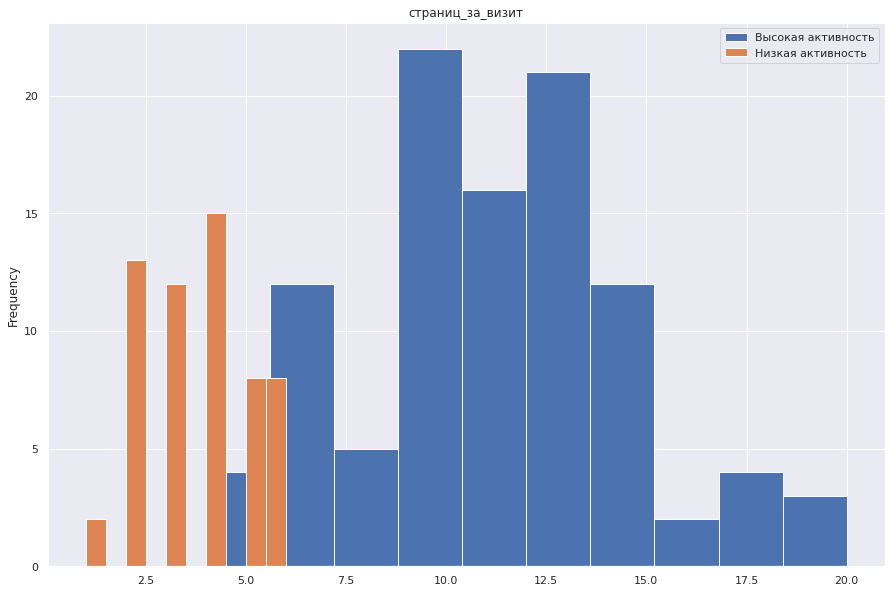

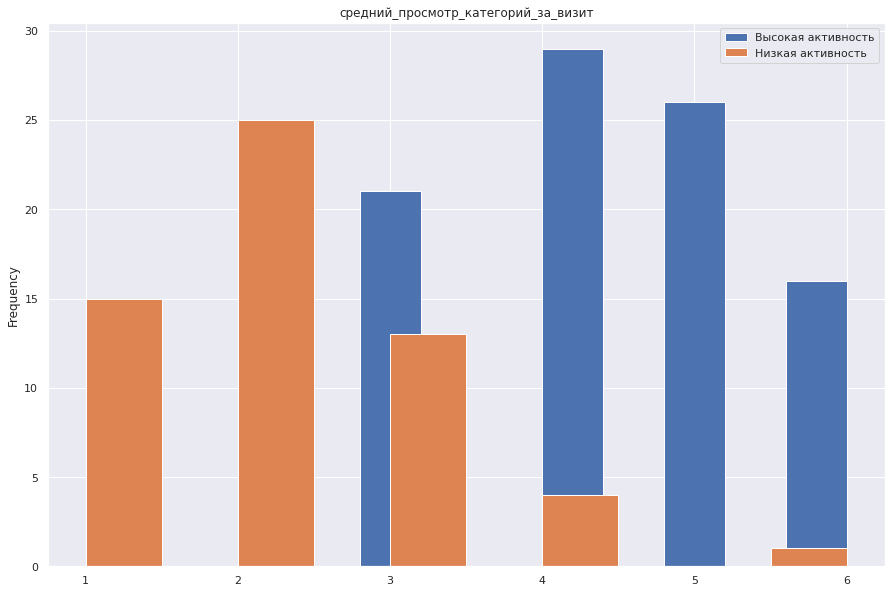

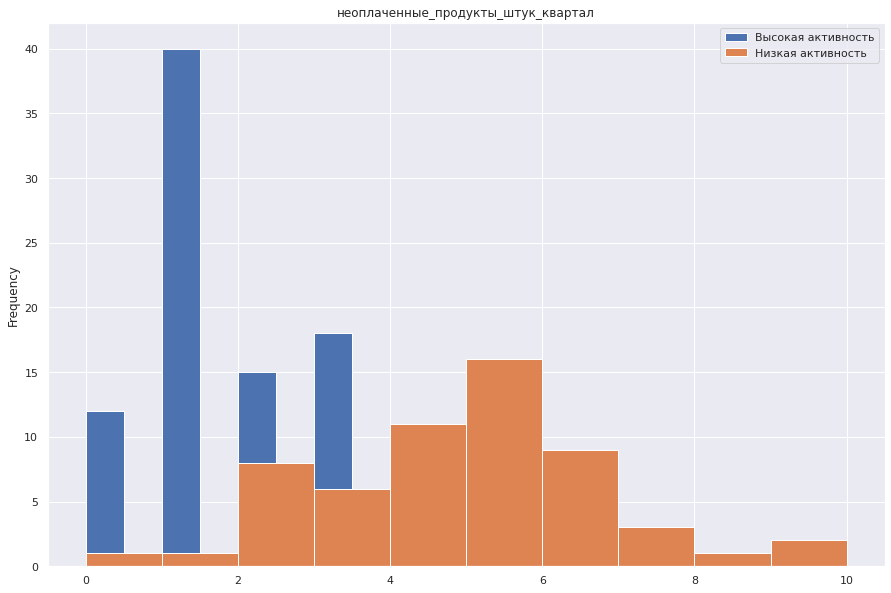

In [145]:
for category in high_impact:
    data_high_activity[category].plot(kind='hist', label='Высокая активность', title=category)
    data_low_activity[category].plot(kind='hist', label='Низкая активность')
    plt.legend()
    plt.show()

In [146]:
_num_cols = data_low_activity[data_low_activity.columns[(data_low_activity.columns != 'длительность')]].select_dtypes(include='number').columns
_num_cols

Index(['актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'выручка_предыдущий_месяц', 'выручка_препредыдущий месяц',
       'выручка_текущий_месяц', 'вероятность_снижения', 'прибыль'],
      dtype='object')

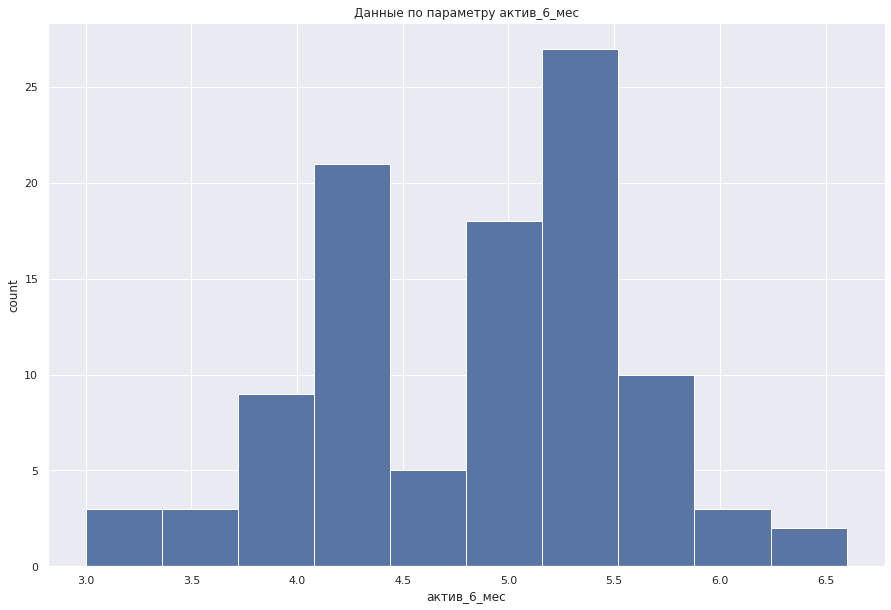

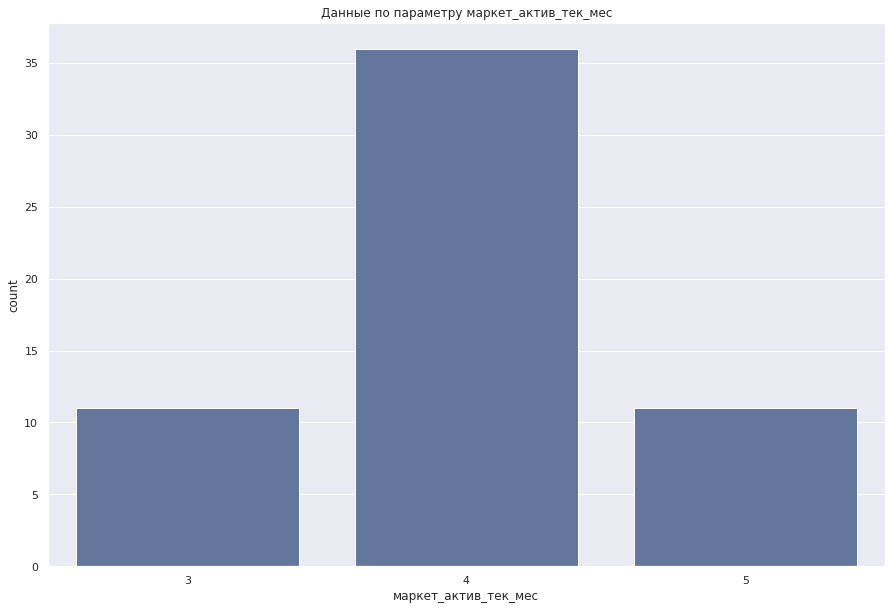

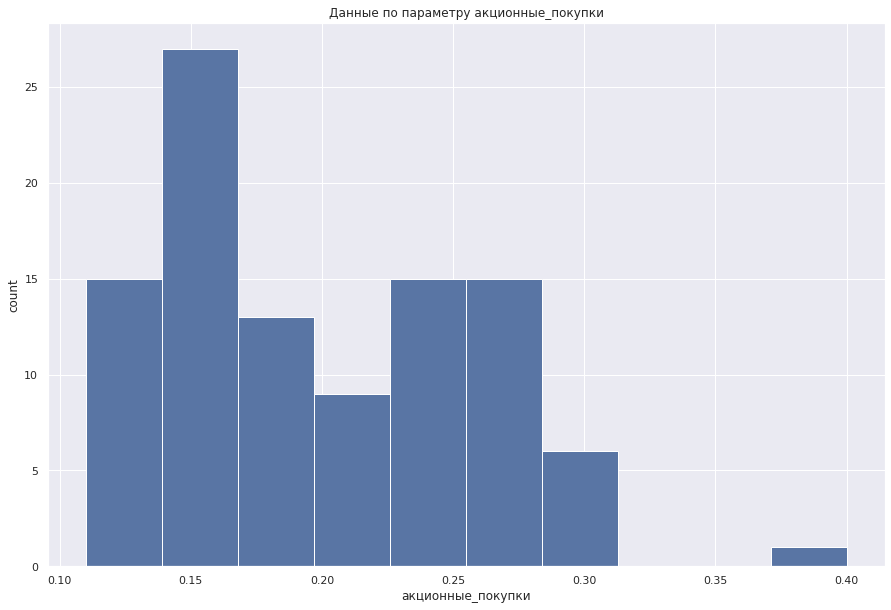

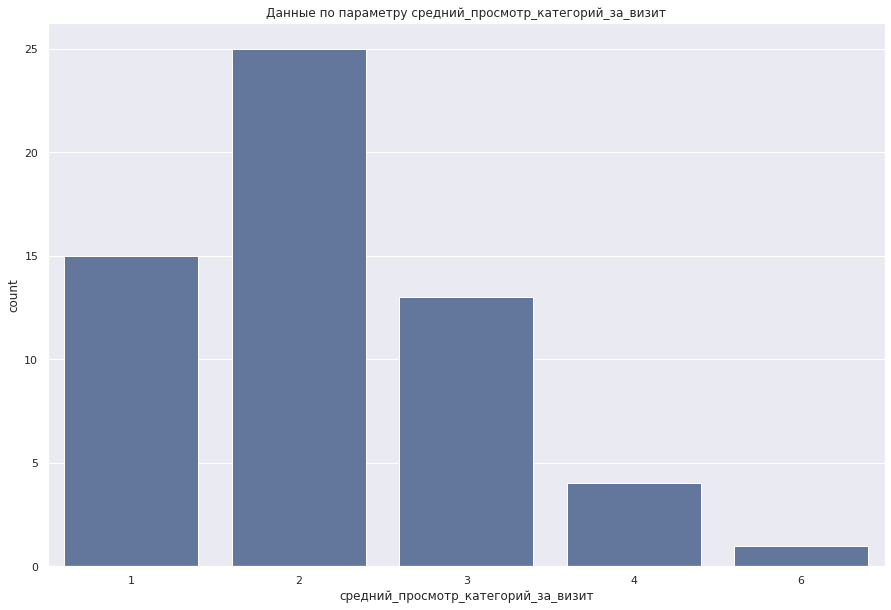

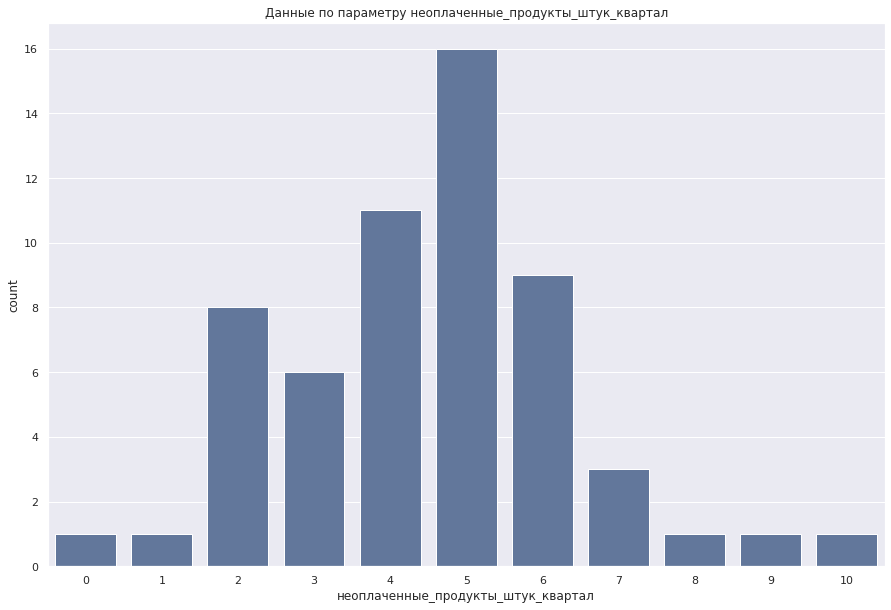

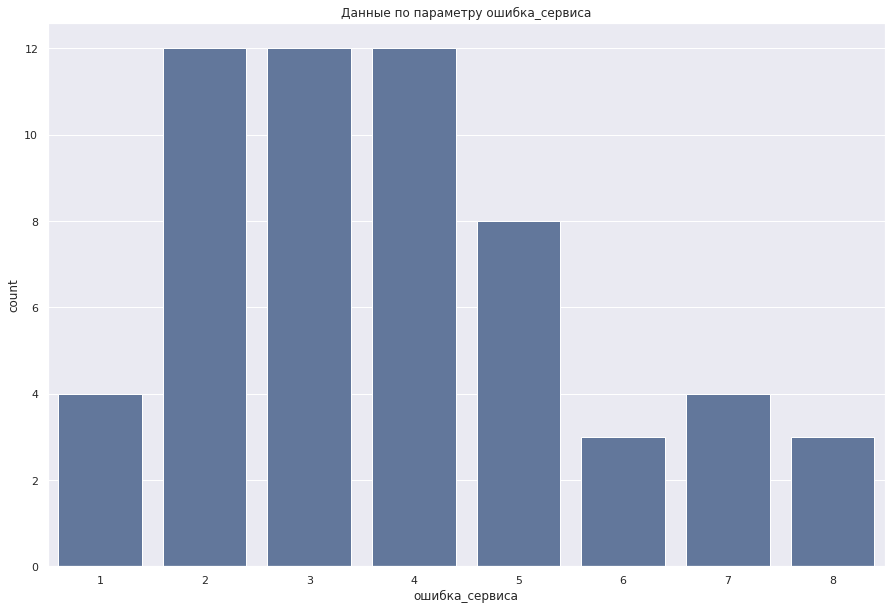

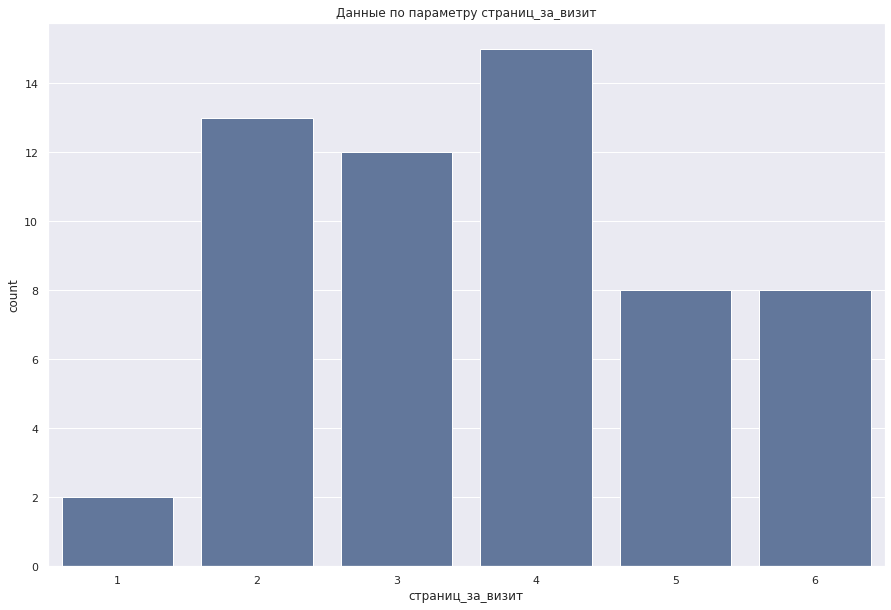

KeyError: 'минут_предыдущий_месяц'

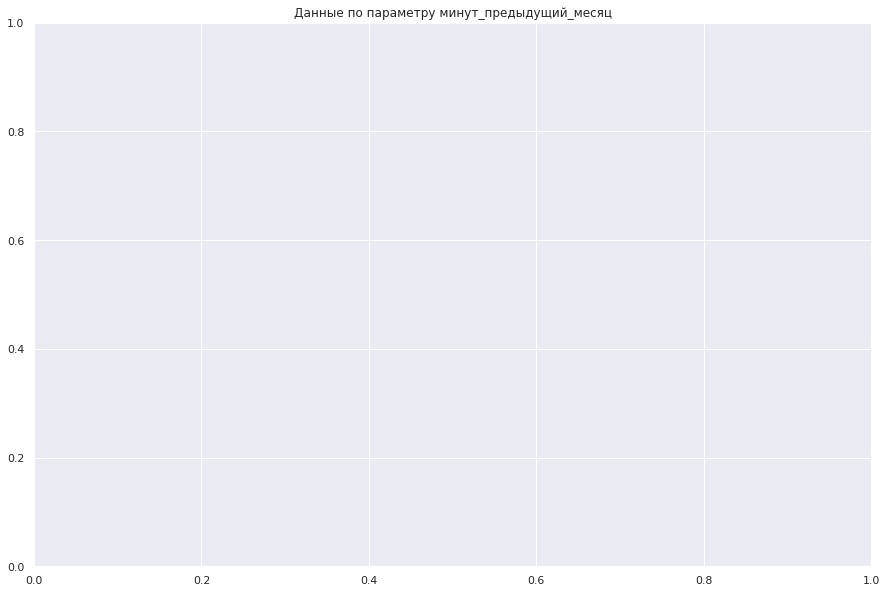

In [147]:
sns.set_theme(rc={'figure.figsize':(15,10)})
for column in _num_cols:
    plt.figure()
    plt.title(f'Данные по параметру {column}')
    
    if market_file[column].dtypes == 'int64':
        sns.countplot(x=column, data=data_low_activity, color='#5975a4')
        
    else:
        data_high_activity[column].plot(kind='hist', y='count', color='#5975a4')
    plt.xlabel(column)    
    plt.ylabel('count')
    plt.show()

In [ ]:
for column in high_impact:
    plt.figure()
    
    plt.title(f'Сравнение групп высокой и низкой покупательской активности по параметру {column}',fontdict = {'fontsize' : 20} )
    sns.histplot(data=data_low_activity[column], stat='density', common_norm=False, color='green')
    sns.histplot(data=data_high_activity[column], stat='density', common_norm=False)
    
    plt.legend(['Низкая активность', 'Высокая активность'])
    plt.show()

**Вывод по сегментации покупателей:**

Из гистрограмм по весомым признакам у самой активной и пассивной групп пользователи:

- с высокой покупательской активностью редко берут по акции
- долго сидят на маркетплейсе
- исследуют больше страниц и категорий
- корзина с минимальным количеством

## ОБЩИЙ ВЫВОД

В целях проекта стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Нами были изучены 4 датасета, в которых была информация:

- Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

- Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом

- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода

- Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

В предобработке данные были приведены к "змеиному регистру" столбцы, были исправлены опечатки. Был произведен поиск на наличие дубликатов и пропусков.

В исследовательском анализе были рассмотрены распределения признаков датасетов, взглянули на круговые диаграммы категориальных признаков, составили список *id*, которые удалили.

Также объединили 3 датасета в один в блоке объединения таблиц.

В корреляционном анализе построили матрицу корреляций, мультиколлинеарность не обнаружили, самая большая корреляция признака "Покупательская активность" наблюдается с признаками страниц_за_визит (0.75), акционные_покупки (0.68), минут_предыдущий_месяц (0.6).

Для поиска лучшей поиска лучшей модели сделали следующее:
- Подготовили данные
- Использовали пайплайны для применения всех изученных моделей
- Обучены 4 модели с подбором гиперпараметров (DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression() и SVC()
- Выбраны метрики для оценки качества модели (ROC-AUC и F1-score)
- Отобрана лучшая модель с лучшими параметрами с помощью RandomizedSearch, лучшей моделью стала LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

В блоке анализа важности выяснили какие параметры влияют на активность, а именно: 

- страниц_за_визит
- средний_просмотр_категорий_за_визит
- минут_предыдущий_месяц
- минут_текущий_месяц
- неоплаченные_продукты_штук_квартал
- акционные_покупки 

Далее была выбрана группа риска, 15% пользователей для которых модель предсказала большую вероятность снижения покупательской активности. Группу риска сравнили с 15% самых активных покупателей, и выявили что группа риска:

Покупки осуществляются по акции, мало сидят на маркетплейсе, держит большое количество товаров в корзине.

Рекомендации: предложить "рИсковым" покупателям спец предложения на товары из их корзин, а также больше акций на группу товаров, которые они просматривают.